<a href="https://colab.research.google.com/github/setarematin/Mini-denoising-Project/blob/main/way1_denosing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!nvidia-smi
!pip -q install kaggle torch torchvision matplotlib scikit-image pandas scikit-learn



Tue Oct  7 15:21:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             33W /   70W |    1064MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
!pip -q install kaggle torch torchvision matplotlib scikit-image pandas scikit-learn


In [16]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle (1).json


In [17]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -la ~/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Oct  7 15:09 .
drwx------ 1 root root 4096 Oct  7 15:09 ..
-rw------- 1 root root   67 Oct  7 15:21 kaggle.json


In [18]:
!rm -rf /content/data/*



In [19]:
!rm -rf /content/data/*
!kaggle datasets download -d prasunroy/natural-images -p /content/data
!unzip -q -o /content/data/natural-images.zip -d /content/data
!ls -lah /content/data/natural_images



Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images
License(s): CC-BY-NC-SA-4.0
 95% 326M/342M [00:06<00:00, 33.9MB/s]
100% 342M/342M [00:06<00:00, 56.6MB/s]
total 272K
drwxr-xr-x 10 root root 4.0K Oct  7 15:21 .
drwxr-xr-x  4 root root 4.0K Oct  7 15:21 ..
drwxr-xr-x  2 root root  32K Oct  7 15:21 airplane
drwxr-xr-x  2 root root  36K Oct  7 15:21 car
drwxr-xr-x  2 root root  32K Oct  7 15:21 cat
drwxr-xr-x  2 root root  20K Oct  7 15:21 dog
drwxr-xr-x  2 root root  32K Oct  7 15:21 flower
drwxr-xr-x  2 root root  36K Oct  7 15:21 fruit
drwxr-xr-x  2 root root  36K Oct  7 15:21 motorbike
drwxr-xr-x  2 root root  36K Oct  7 15:21 person


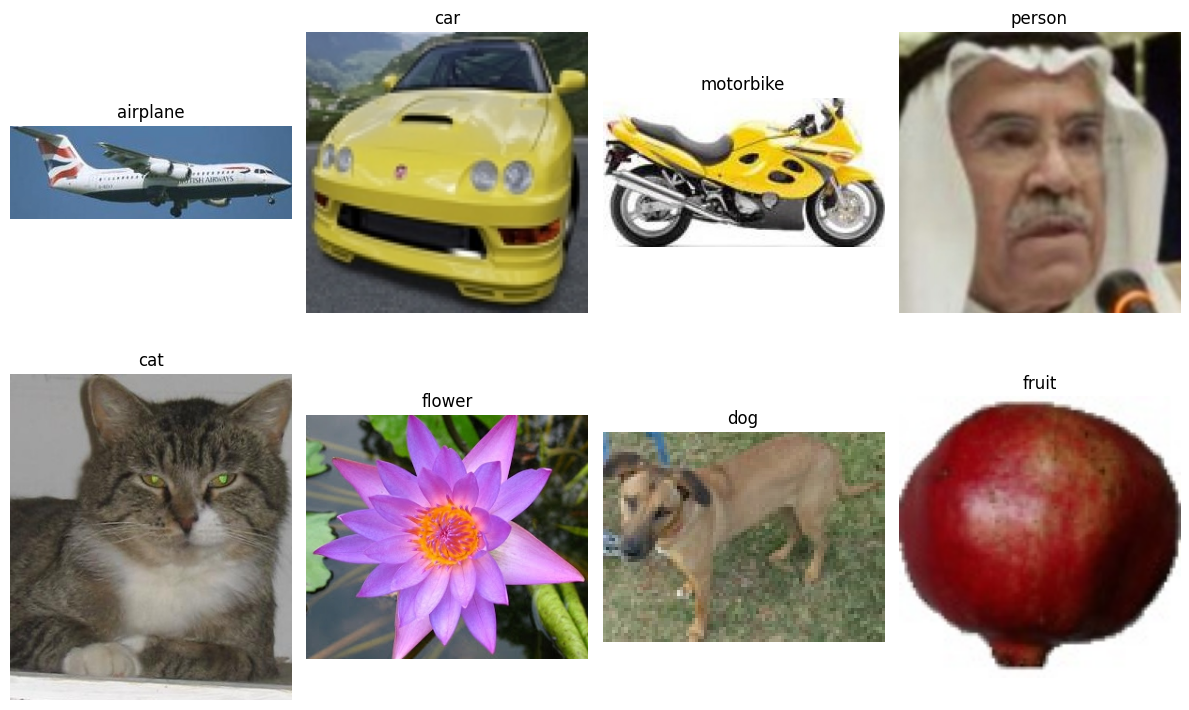

In [20]:
#visual sanity check

import matplotlib.pyplot as plt   #plotting library (like Excel charts, but in Python). We’ll use it to show images in a grid.
import os, random                 #Python’s tool to work with files and folders (like listing, joining paths).
from PIL import Image             #PIL (Python Imaging Library) → helps to open and manipulate image files.

DATA_DIR = "/content/data/natural_images"     #where to look for the images.

# Pick 8 random images (one from each class if possible)
classes = os.listdir(DATA_DIR)
plt.figure(figsize=(12,8))

for i, cls in enumerate(classes):   # i → the index (0,1,2,…7) , cls → the class name (e.g., “cat”). #bc of enumerate, You’ll get both the index number and the item:
    cls_path = os.path.join(DATA_DIR, cls) #If cls="cat", then cls_path = /content/data/natural_images/cat
    img_file = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_file)
    img = Image.open(img_path)
    plt.subplot(2,4,i+1) #Creates a grid of plots inside the big figure. means 2 rows × 4 columns = 8 slots total. i+1 : selects the current slot (matplotlib starts counting at 1, not 0).
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off") #Hides the x and y axes (no pixel numbers, just the picture).

plt.tight_layout() #Adjusts spacing so images don’t overlap and titles look nice.
plt.show()


In [21]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

DATA_DIR = "/content/data/natural_images"

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(num_output_channels=3),  # replicate gray → 3 channels
    transforms.ToTensor(),                        # [0,1]
])

full_ds = datasets.ImageFolder(root=DATA_DIR, transform=transform)

# 80/20 split (reproducible)
g = torch.Generator().manual_seed(42)       ## reproducible split - ensures we always get the same random split each time we run the code.
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size], generator=g) #PyTorch helper function split the dataset randomly:  (dataset, lengths, generator=None)

print("Classes:", full_ds.classes, " | sizes:", len(train_ds), len(val_ds))


Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']  | sizes: 5519 1380


In [22]:
#A
import math
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, base_ds, snr_db=20):
        self.base_ds = base_ds
        self.snr_db = snr_db

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        clean_img, _ = self.base_ds[idx]  # tensor in [0,1], shape (3,H,W)
        signal_power = clean_img.pow(2).mean()  # target noise power from SNR (SNR = 10 log10(Ps/Pn))
        snr = 10 ** (self.snr_db / 10)  # Convert SNR from decibel (log) scale to linear scale for noise power calculation
        noise_power = signal_power / snr
        noise = torch.randn_like(clean_img) * math.sqrt(noise_power) # Generate Gaussian noise (mean=0, variance=noise_power) with same shape as image
        noisy_img = (clean_img + noise).clamp(0., 1.) #Clamp” means force all values into a fixed range — here between 0 and 1.
        return noisy_img, clean_img  # (input, target)

train_noisy = NoisyDataset(train_ds, snr_db=20)
val_noisy   = NoisyDataset(val_ds,   snr_db=20)

train_loader = DataLoader(train_noisy, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_noisy, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [23]:
noisy, clean = train_noisy[0]
print("Sample shapes:", noisy.shape, clean.shape)  # should be (3,128,128)


Sample shapes: torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


In [24]:
#B
!pip -q install segmentation-models-pytorch timm

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",        # prebuilt encoder (residual) - extract detailed features (edges and..)
    encoder_weights="imagenet",     # pretrained
    in_channels=3,                  # matches our 3-ch transform
    classes=1,                      # 1-channel output (regression to grayscale)
    activation=None                 # no sigmoid; we treat this as regression, refers only to the final output layer
).to(device)

print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M | device: {device}") #p.numel: number of elements, 1e6:.2f: 1M and the string formatting


Model params: 24.44M | device: cuda


In [25]:
#D
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity #PSNR, SSIM
import numpy as np

criterion = nn.L1Loss()                              # Loss function : L1 is better and sharper output cuz MSE(Mean Squered Errors) blurr the image- punish big- more coutios
optimizer = optim.Adam(model.parameters(), lr=1e-3)  #Optimizer: Adam (which weights to update, learning rate) : Adam adjusts the model weights to minimize the loss after each batch.
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda")) #Makes training faster and memory-efficient on GPUs without losing accuracy.

@torch.no_grad()   #bc we gonna use the function for validation just to check the performance
def batch_metrics(pred, target):
    # prediction/target: (B,1,H,W) in [0,1]; clamp: ensure pixel values are valid, detach: remove gradient info.
    pred = pred.clamp(0,1).detach().cpu().numpy()
    target = target.clamp(0,1).detach().cpu().numpy()
    psnrs, ssims = [], []
    for i in range(pred.shape[0]):        #pred.shape[0]: means the first dimension of the tensor → the batch size.
        p = pred[i,0]; t = target[i,0]              # single-channel compare, # 'i' = batch index, '0' = first (and only) channel → extract 2D grayscale image
        psnrs.append(peak_signal_noise_ratio(t, p, data_range=1.0)) #data range: maximum possible value minus the minimum possible value
        ssims.append(structural_similarity(t, p, data_range=1.0))
    return float(np.mean(psnrs)), float(np.mean(ssims))


/tmp/ipython-input-4117043975.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda")) #Makes training faster and memory-efficient on GPUs without losing accuracy.


In [28]:
#E
import math
from pathlib import Path
ckpt_path = Path("/content/best_unet_resnet34_imagenet.pth")

def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    total_loss = 0.0
    for noisy, clean in loader:
        # noisy: (B,3,H,W), clean: (B,3,H,W)
        noisy = noisy.to(device)
        clean = clean[:, :1].to(device)     # target = luminance (first channel)
        optimizer.zero_grad(set_to_none=True) #free the memory

        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            pred = model(noisy)             # (B,1,H,W)
            loss = criterion(pred, clean)   # L1 on [0,1] images

        scaler.scale(loss).backward()       # backprop (with scaling)
        scaler.step(optimizer)              # update weights
        scaler.update()                     # adjust scaling for next iter

        total_loss += loss.item() * noisy.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_psnr, all_ssim = [], []
    for noisy, clean in loader:
        noisy = noisy.to(device)
        clean = clean[:, :1].to(device)     # compare to single-channel target
        pred = model(noisy)
        loss = criterion(pred, clean)
        total_loss += loss.item() * noisy.size(0)

        psnr, ssim = batch_metrics(pred, clean)
        all_psnr.append(psnr); all_ssim.append(ssim)

    return (
        total_loss / len(loader.dataset),
        float(np.mean(all_psnr)),
        float(np.mean(all_ssim)),
    )

epochs = 50
best = math.inf #start “best val loss” at infinity.
for ep in range(1, epochs+1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    va, ps, ss = validate(model, val_loader, criterion, device) #validate → mean val loss/PSNR/SSIM.
    print(f"Epoch {ep:02d} | train L1={tr:.4f} | val L1={va:.4f} | PSNR={ps:.2f} | SSIM={ss:.4f}")
    if va < best:      #if validation improved
        best = va
        torch.save(model.state_dict(), ckpt_path) #save weights (checkpoint).
        print("saved:", ckpt_path)


/tmp/ipython-input-2500036724.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01 | train L1=0.0194 | val L1=0.0294 | PSNR=33.19 | SSIM=0.9422
saved: /content/best_unet_resnet34_imagenet.pth
Epoch 02 | train L1=0.0194 | val L1=0.0208 | PSNR=33.44 | SSIM=0.9414
saved: /content/best_unet_resnet34_imagenet.pth
Epoch 03 | train L1=0.0196 | val L1=0.0290 | PSNR=33.14 | SSIM=0.9429
Epoch 04 | train L1=0.0184 | val L1=0.0346 | PSNR=31.28 | SSIM=0.9387
Epoch 05 | train L1=0.0187 | val L1=0.0178 | PSNR=33.88 | SSIM=0.9473
saved: /content/best_unet_resnet34_imagenet.pth
Epoch 06 | train L1=0.0188 | val L1=0.0218 | PSNR=31.69 | SSIM=0.9353
Epoch 07 | train L1=0.0192 | val L1=0.0353 | PSNR=29.35 | SSIM=0.9192
Epoch 08 | train L1=0.0211 | val L1=0.0303 | PSNR=31.64 | SSIM=0.9378
Epoch 09 | train L1=0.0197 | val L1=0.0183 | PSNR=32.93 | SSIM=0.9413
Epoch 10 | train L1=0.0197 | val L1=0.0195 | PSNR=33.82 | SSIM=0.9425
Epoch 11 | train L1=0.0184 | val L1=0.0226 | PSNR=31.83 | SSIM=0.9415
Epoch 12 | train L1=0.0185 | val L1=0.0196 | PSNR=33.27 | SSIM=0.9409
Epoch 13 | train

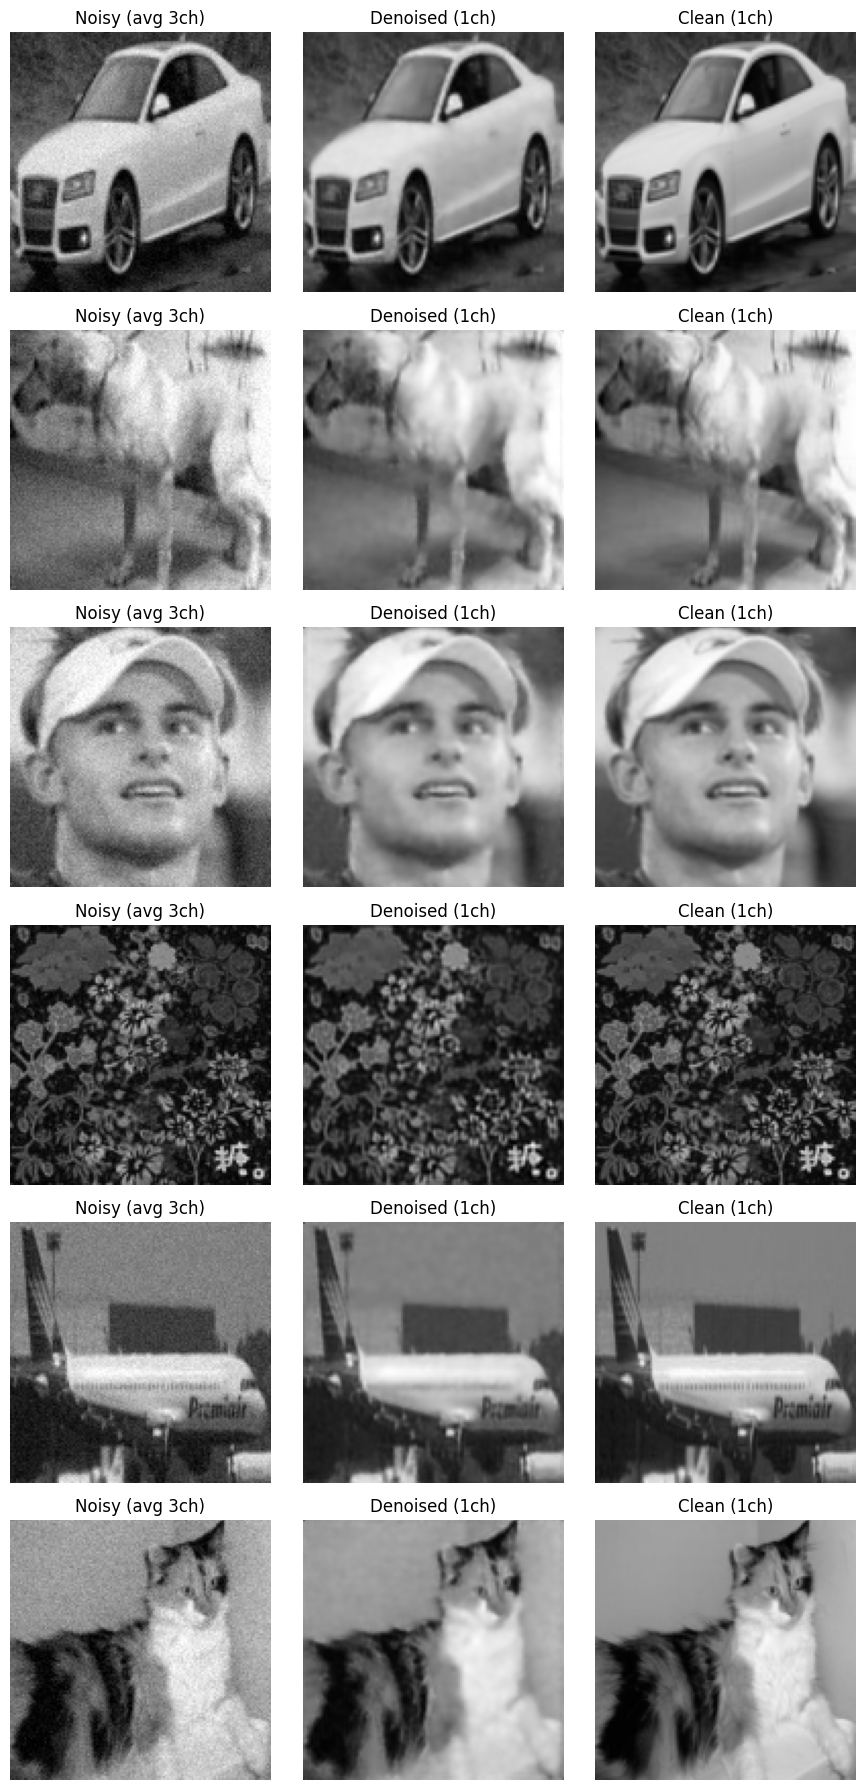

In [27]:
#F
import matplotlib.pyplot as plt

@torch.no_grad()
def show_examples(model, loader, k=6):
    model.eval()
    noisy, clean = next(iter(loader))
    noisy = noisy.to(device)
    clean = clean[:, :1].to(device)        # 1-ch target
    pred = model(noisy).clamp(0,1)

    k = min(k, noisy.size(0)) #In case batch smaller than k, cap it to avoid index errors.
    fig, axes = plt.subplots(k, 3, figsize=(9, 3*k))
    for i in range(k):
        nimg = noisy[i].detach().cpu().mean(0)     # show mean of 3ch as gray
        pimg = pred[i,0].detach().cpu() #.detach() → stop tracking gradients.
        cimg = clean[i,0].detach().cpu()

        axes[i,0].imshow(nimg, cmap='gray', vmin=0, vmax=1); axes[i,0].set_title("Noisy (avg 3ch)"); axes[i,0].axis("off") #fix pixel intensity scale (ensures black=0, white=1).
        axes[i,1].imshow(pimg, cmap='gray', vmin=0, vmax=1); axes[i,1].set_title("Denoised (1ch)");  axes[i,1].axis("off")
        axes[i,2].imshow(cimg, cmap='gray', vmin=0, vmax=1); axes[i,2].set_title("Clean (1ch)");     axes[i,2].axis("off")

    plt.tight_layout(); plt.show()

show_examples(model, val_loader, k=6)
